In [3]:
## Import Libraries
#! pip install optuna
! pip install attention

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import logging
import sys

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from attention import Attention
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import optuna
from sklearn.model_selection import StratifiedKFold

from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler

from sklearn.metrics import f1_score,classification_report,confusion_matrix

import warnings
warnings.filterwarnings('ignore')

random = 14

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [5]:
## Reading Datasets
D = pd.read_csv('/kaggle/input/project2/train_augmented_synonym.csv')
test = pd.read_csv('/kaggle/input/project2/test.csv')
# test_labels = pd.read_csv(test_labels_path)[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
# test = pd.concat([test, test_labels],axis=1)
# test = test.loc[test['toxic'] != -1]

# D = pd.concat([train, test], axis=0)

#### Exploratory Data Analysis

In [7]:
## Checking Null Entries
print("Number of Null Data: " + str(D.isnull().sum().sum()))

## Checking Dimensions
print("Number of Variables: ")
print(D.shape[1])
print("\nNumber of Data Points: ")
print(D.shape[0])

## Structure of the Dataset
D.head()

Number of Null Data: 0
Number of Variables: 
4

Number of Data Points: 
281304


,Unnamed: 0,id,comment_text,malignant
0,3540,0984c26029e44887,"""\n\nIt is not disruptive, and does not appear...",1
1,109256,4849430cafecf8d4,"""\n\n Blackstar (David Bowie) \n\nI am not try...",0
2,81855,889cba217d778f24,""". Criminal pedophile UBS economy of Ospel and...",0
3,131019,bd123e7f45e36a6b,"""The -'s clearly attaches to the end of a full...",0
4,71335,bef4c307d829b7e6,Unnecessary addition of external image \n\nHel...,0


In [47]:
## Checks for Creating New Dependent Variable
def analyze_var(df, col_list):
    col_list_v = col_list[1:]
    res = pd.DataFrame(col_list_v)
    for dv in col_list_v:
        count = []
        D_dv = D.loc[D[dv]==1]
        for dv2 in col_list_v:
            D_dv_dv2 = D_dv.loc[D_dv[dv2]==1]
            count.append(D_dv_dv2.shape[0])
        res = pd.concat([res,pd.DataFrame(count)],axis=1)
    res.columns = col_list
    return res

analyze_var(D, ['var_count','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

,var_count,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,toxic,21384,1962,11552,654,10686,1995
1,severe_toxic,1962,1962,1880,158,1701,448
2,obscene,11552,1880,12140,439,8884,1570
3,threat,654,158,439,689,445,145
4,insult,10686,1701,8884,445,11304,1762
5,identity_hate,1995,448,1570,145,1762,2117


In [6]:
## Create New Dependent Variable - Malignant
def force_one(x):
    if x > 1:
        return 1
    else:
        return x

D['malignant'] = D['toxic'] + D['obscene'] + D['threat'] + D['insult'] + D['identity_hate']
D['malignant'] = D['malignant'].apply(lambda x: force_one(x))
D = D[['id','comment_text','malignant']]

D.head()

,id,comment_text,malignant
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


Number of Non-Malignant Comments: 140652
Number of Malignant Comments: 140652


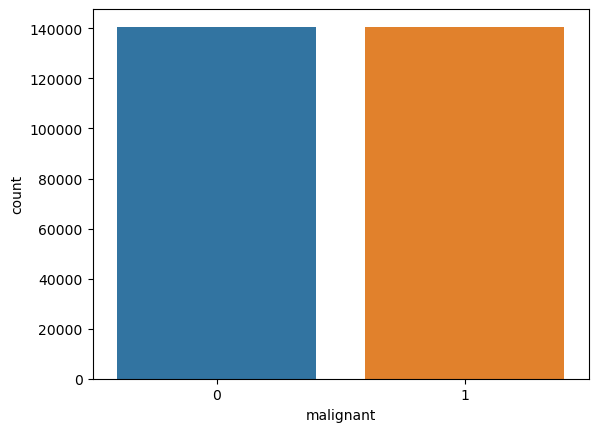

In [8]:
## Distribution of Dependent Variable - Malignant
sns.countplot(data = D, x= 'malignant')
print("Number of Non-Malignant Comments: {0}".format(sum(D['malignant'] == 0)))
print("Number of Malignant Comments: {0}".format(sum(D['malignant'] == 1)))

#### Preprocessing and Feature Extraction

Puncuations that are found to express emotions in chats are counted separately once again. Those punctuations are chosen from the sources below:

1. "The interactional principle in digital punctuation": https://www.sciencedirect.com/science/article/pii/S2211695821000180
2. "Punctuation is the New Measure of Emotion": https://ericadhawan.medium.com/punctuation-is-the-new-measure-of-emotion-329b684743f0

In [9]:
## Text Feature Extraction - D

#### Make Strings to Lower Case
D['comment_text'] = D['comment_text'].str.lower()

#### Keep Track of String's Original Length
D['length'] = D['comment_text'].str.len()

#### Replace Email Address with 'email'
D['comment_text'] = D['comment_text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','email')

#### Replace Website Address with 'website'
D['comment_text'] = D['comment_text'].str.replace(r'^http[s]{0,1}\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','website')

#### Replace Website Address with 'phonenumber'
D['comment_text'] = D['comment_text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber') # Note, might contain a random 10 digit number.

#### Replace Numbers with 'numbrs'
D['comment_text'] = D['comment_text'].str.replace(r'\d+(\.\d+)?', 'numbr')

#### Special Punctuations are Replaced Explicitly.
D['comment_text'] = D['comment_text'].str.replace(r'!',' exclamationmark')
D['comment_text'] = D['comment_text'].str.replace(r'\?',' questionmark')
D['comment_text'] = D['comment_text'].str.replace(r'\.{1}',' periodmark')
D['comment_text'] = D['comment_text'].str.replace(r'\.{2,}',' ellipsismark')
D['comment_text'] = D['comment_text'].str.replace(r'£|\$', ' dollers')

## Removing Leftover Punctuations
def remove_punct(text):
    p_free="".join([i for i in text if i not in string.punctuation])
    return p_free
D['comment_text'] = D['comment_text'].apply(lambda x:remove_punct(x))

In [11]:
## Text Pre-Processing - Test

#### Make Strings to Lower Case
test['comment_text'] = test['comment_text'].str.lower()

#### Keep Track of String's Original Length
test['length'] = test['comment_text'].str.len()

#### Replace Email Address with 'email'
test['comment_text'] = test['comment_text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','email')

#### Replace Website Address with 'website'
test['comment_text'] = test['comment_text'].str.replace(r'^http[s]{0,1}\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','website')

#### Replace Website Address with 'phonenumber'
test['comment_text'] = test['comment_text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber') # Note, might contain a random 10 digit number.

#### Replace Numbers with 'numbrs'
test['comment_text'] = test['comment_text'].str.replace(r'\d+(\.\d+)?', 'numbr')

#### Special Punctuations are Replaced Explicitly.
test['comment_text'] = test['comment_text'].str.replace(r'!',' exclamationmark')
test['comment_text'] = test['comment_text'].str.replace(r'\?',' questionmark')
test['comment_text'] = test['comment_text'].str.replace(r'\.{1}',' periodmark')
test['comment_text'] = test['comment_text'].str.replace(r'\.{2,}',' ellipsismark')
test['comment_text'] = test['comment_text'].str.replace(r'£|\$', ' dollers')

## Removing Leftover Punctuations
def remove_punct(text):
    p_free="".join([i for i in text if i not in string.punctuation])
    return p_free
test['comment_text'] = test['comment_text'].apply(lambda x:remove_punct(x))

In [13]:
## Tokenizing Strings
X_train = D['comment_text']
y_train = D['malignant']
X_test = test['comment_text']
y_test = test['malignant']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random)

train_text = X_train.fillna("_na_").values
test_text = X_test.fillna("_na_").values

max_features = 20000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_text))
tokenized_train = tokenizer.texts_to_sequences(train_text)
tokenized_test = tokenizer.texts_to_sequences(test_text)

In [14]:
print("Number of observations in X_train: {}".format(X_train.shape[0]))
print("Number of observations in X_test: {}".format(X_test.shape[0]))

Number of observations in X_train: 281304
Number of observations in X_test: 67065


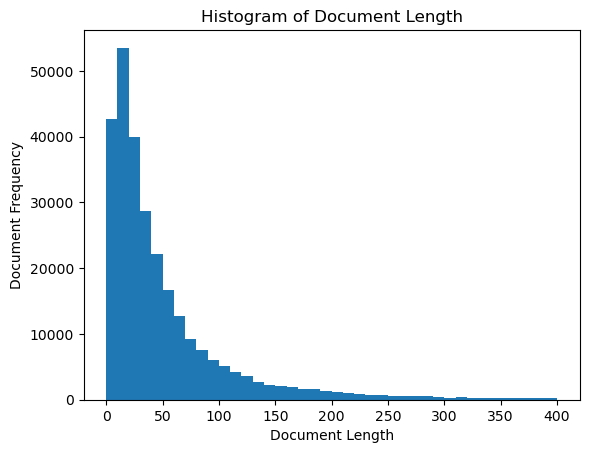

In [15]:
## Distribution of Number of Words.
totalNumWords = [len(text) for text in tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.title('Histogram of Document Length')
plt.ylabel('Document Frequency')
plt.xlabel('Document Length')
plt.show()

In [16]:
## Pad the Tokenized List - Evening Length
maxlen = 150
X_train = pad_sequences(tokenized_train, maxlen=maxlen)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [19]:
def build_lstm(hp, maxlen, max_features, X, y):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, hp['embed_size'])(inp)
    x = Bidirectional(LSTM(hp['op_lstm_size'], return_sequences=True, dropout=hp['dropout_lstm'], recurrent_dropout=0))(x)
    if hp['attention'] == 1:
        x = Attention(units=hp['attention_units'])(x)
    else:
        x = GlobalMaxPool1D()(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(hp['dropout'])(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(), 
                  metrics=['accuracy'])
    X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.5, random_state=random)
    model.fit(X_t, y_t, epochs=hp['epochs'], batch_size=hp['batch_size'])
    y_pred = model.predict([X_v], batch_size=256, verbose=1)
    y_pred = (y_pred > 0.5).astype(int)
    score = f1_score(y_v, y_pred, average = 'macro')
    return model, score#np.mean(scores)

def build_lstm_cv(hp, maxlen, max_features, X, y, cv):
    scores = []
    skf = StratifiedKFold(n_splits=cv)
    for i, (train_index, test_index) in enumerate(skf.split(X,y)):
        inp = Input(shape=(maxlen, ))
        x = Embedding(max_features, hp['embed_size'])(inp)
        if hp['bidirectional'] == 1:
            x = Bidirectional(LSTM(hp['op_lstm_size'], return_sequences=True, dropout=hp['dropout_lstm'], recurrent_dropout=0))(x)
        else:
            x = LSTM(hp['op_lstm_size'], return_sequences=True, dropout=hp['dropout_lstm'], recurrent_dropout=0)(x)
        if hp['attention'] == 1:
            x = Attention(units=hp['attention_units'])(x)
        else:
            x = GlobalMaxPool1D()(x)
        x = Dense(50, activation='relu')(x)
        x = Dropout(hp['dropout'])(x)
        x = Dense(1, activation="sigmoid")(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='binary_crossentropy', 
                      optimizer=optimizers.Adam(), 
                      metrics=['accuracy'])
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_true = y[test_index]
        model.fit(X_train, y_train, epochs=hp['epochs'], batch_size=hp['batch_size'])
        gc.collect()
        y_pred = model.predict([X_test], batch_size=256, verbose=1)
        y_pred = (y_pred > 0.5).astype(int)
        scores.append(f1_score(y_true, y_pred, average = 'macro'))
        gc.collect()
        # You can add something here if you want to keep track of cv scores independently.
    return model, np.mean(scores)
        
def objective(trial, maxlen, max_features, X, y, cv, apply_cv = False):
    hp = {
        'embed_size': trial.suggest_int('embed_size', 64, 256, step = 64),
        'op_lstm_size': trial.suggest_int('op_lstm_size', 50, 60),
        'dropout_lstm': trial.suggest_float('dropout_lstm', 0, 0.5),
        'dropout': trial.suggest_float('dropout', 0, 0.5),
        'epochs': trial.suggest_int('epochs', 2, 5),
        'batch_size': trial.suggest_categorical('batch_size', [128,256,512,1024]),
        'attention': trial.suggest_categorical('attention', [0,1]),
        'attention_units': trial.suggest_categorical('attention_units', [16,32,64]),
        'bidirectional': trial.suggest_categorical('bidirectional', [0,1])
    }
    
    model, f1macro = build_lstm(hp, maxlen, max_features, X, y)

    return f1macro

In [17]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "cs3244-lstm-study-f1_macro" 
storage_name = "sqlite:///{}.db".format(study_name)

In [ ]:
#import os
#os.system('rm /kaggle/working/cs3244-lstm-study-f1_macro.csv')
#os.system('cp /kaggle/input/cs3244-lstm/cs3244-lstm-study.db /kaggle/working/cs3244-lstm-study.db')

In [21]:
cv = 5
study = optuna.create_study(direction="maximize", sampler=TPESampler(), pruner=SuccessiveHalvingPruner(),
                           study_name=study_name, storage=storage_name, load_if_exists=True)
func = lambda trial: objective(trial, maxlen, max_features, X_train, y_train, cv, apply_cv = False)
study.optimize(func, n_trials=100, gc_after_trial=True)

[I 2023-04-07 15:02:34,709] Using an existing study with name 'cs3244-lstm-study-f1_macro' instead of creating a new one.


Using an existing study with name 'cs3244-lstm-study-f1_macro' instead of creating a new one.
Epoch 1/5
550/550 [==============================] - 22s 34ms/step - loss: 0.1705 - accuracy: 0.9284
Epoch 2/5
550/550 [==============================] - 18s 33ms/step - loss: 0.0825 - accuracy: 0.9698
Epoch 3/5
550/550 [==============================] - 18s 33ms/step - loss: 0.0603 - accuracy: 0.9782
Epoch 4/5
550/550 [==============================] - 18s 33ms/step - loss: 0.0432 - accuracy: 0.9849
Epoch 5/5
550/550 [==============================] - 6s 10ms/step


[I 2023-04-07 15:05:11,586] Trial 2 finished with value: 0.9610030426381659 and parameters: {'embed_size': 256, 'op_lstm_size': 53, 'dropout_lstm': 0.329328946255611, 'dropout': 0.06621852362191555, 'epochs': 5, 'batch_size': 256, 'attention': 0, 'attention_units': 16, 'bidirectional': 1}. Best is trial 1 with value: 0.9620197282921605.


Trial 2 finished with value: 0.9610030426381659 and parameters: {'embed_size': 256, 'op_lstm_size': 53, 'dropout_lstm': 0.329328946255611, 'dropout': 0.06621852362191555, 'epochs': 5, 'batch_size': 256, 'attention': 0, 'attention_units': 16, 'bidirectional': 1}. Best is trial 1 with value: 0.9620197282921605.
Epoch 1/5
550/550 [==============================] - 21s 32ms/step - loss: 0.1695 - accuracy: 0.9325
Epoch 2/5
550/550 [==============================] - 17s 31ms/step - loss: 0.0842 - accuracy: 0.9698
Epoch 3/5
550/550 [==============================] - 17s 32ms/step - loss: 0.0637 - accuracy: 0.9772
Epoch 4/5
550/550 [==============================] - 17s 31ms/step - loss: 0.0482 - accuracy: 0.9824
Epoch 5/5
550/550 [==============================] - 7s 11ms/step


[I 2023-04-07 15:07:49,419] Trial 3 finished with value: 0.9622472441314562 and parameters: {'embed_size': 192, 'op_lstm_size': 50, 'dropout_lstm': 0.4223654818134945, 'dropout': 0.3262212844589758, 'epochs': 5, 'batch_size': 256, 'attention': 1, 'attention_units': 64, 'bidirectional': 0}. Best is trial 3 with value: 0.9622472441314562.


Trial 3 finished with value: 0.9622472441314562 and parameters: {'embed_size': 192, 'op_lstm_size': 50, 'dropout_lstm': 0.4223654818134945, 'dropout': 0.3262212844589758, 'epochs': 5, 'batch_size': 256, 'attention': 1, 'attention_units': 64, 'bidirectional': 0}. Best is trial 3 with value: 0.9622472441314562.
Epoch 1/3
550/550 [==============================] - 20s 30ms/step - loss: 0.1698 - accuracy: 0.9308
Epoch 2/3
550/550 [==============================] - 16s 29ms/step - loss: 0.0848 - accuracy: 0.9690
Epoch 3/3
550/550 [==============================] - 6s 10ms/step


[I 2023-04-07 15:08:54,102] Trial 4 finished with value: 0.9624518421081812 and parameters: {'embed_size': 128, 'op_lstm_size': 57, 'dropout_lstm': 0.22858185722184593, 'dropout': 0.08880200179352454, 'epochs': 3, 'batch_size': 256, 'attention': 1, 'attention_units': 64, 'bidirectional': 0}. Best is trial 4 with value: 0.9624518421081812.


Trial 4 finished with value: 0.9624518421081812 and parameters: {'embed_size': 128, 'op_lstm_size': 57, 'dropout_lstm': 0.22858185722184593, 'dropout': 0.08880200179352454, 'epochs': 3, 'batch_size': 256, 'attention': 1, 'attention_units': 64, 'bidirectional': 0}. Best is trial 4 with value: 0.9624518421081812.
Epoch 1/3
550/550 [==============================] - 15s 22ms/step - loss: 0.2071 - accuracy: 0.9139
Epoch 2/3
550/550 [==============================] - 12s 22ms/step - loss: 0.0918 - accuracy: 0.9676
Epoch 3/3
550/550 [==============================] - 5s 8ms/step


[I 2023-04-07 15:09:44,961] Trial 5 finished with value: 0.9609871940213772 and parameters: {'embed_size': 64, 'op_lstm_size': 58, 'dropout_lstm': 0.07271186856839179, 'dropout': 0.40683049204928406, 'epochs': 3, 'batch_size': 256, 'attention': 0, 'attention_units': 16, 'bidirectional': 1}. Best is trial 4 with value: 0.9624518421081812.


Trial 5 finished with value: 0.9609871940213772 and parameters: {'embed_size': 64, 'op_lstm_size': 58, 'dropout_lstm': 0.07271186856839179, 'dropout': 0.40683049204928406, 'epochs': 3, 'batch_size': 256, 'attention': 0, 'attention_units': 16, 'bidirectional': 1}. Best is trial 4 with value: 0.9624518421081812.
Epoch 1/4
138/138 [==============================] - 12s 62ms/step - loss: 0.3128 - accuracy: 0.8525
Epoch 2/4
138/138 [==============================] - 9s 62ms/step - loss: 0.1061 - accuracy: 0.9646
Epoch 3/4
138/138 [==============================] - 9s 63ms/step - loss: 0.0809 - accuracy: 0.9738
Epoch 4/4
550/550 [==============================] - 5s 9ms/step


[I 2023-04-07 15:10:36,307] Trial 6 finished with value: 0.9608607153353312 and parameters: {'embed_size': 64, 'op_lstm_size': 50, 'dropout_lstm': 0.023862332437187495, 'dropout': 0.4181866146144365, 'epochs': 4, 'batch_size': 1024, 'attention': 1, 'attention_units': 16, 'bidirectional': 0}. Best is trial 4 with value: 0.9624518421081812.


Trial 6 finished with value: 0.9608607153353312 and parameters: {'embed_size': 64, 'op_lstm_size': 50, 'dropout_lstm': 0.023862332437187495, 'dropout': 0.4181866146144365, 'epochs': 4, 'batch_size': 1024, 'attention': 1, 'attention_units': 16, 'bidirectional': 0}. Best is trial 4 with value: 0.9624518421081812.
Epoch 1/3
138/138 [==============================] - 16s 92ms/step - loss: 0.2745 - accuracy: 0.8794
Epoch 2/3
138/138 [==============================] - 13s 93ms/step - loss: 0.0965 - accuracy: 0.9658
Epoch 3/3
550/550 [==============================] - 6s 9ms/step


[I 2023-04-07 15:11:25,536] Trial 7 finished with value: 0.9618486050748238 and parameters: {'embed_size': 192, 'op_lstm_size': 60, 'dropout_lstm': 0.3762757552251475, 'dropout': 0.30213157200779744, 'epochs': 3, 'batch_size': 1024, 'attention': 0, 'attention_units': 16, 'bidirectional': 1}. Best is trial 4 with value: 0.9624518421081812.


Trial 7 finished with value: 0.9618486050748238 and parameters: {'embed_size': 192, 'op_lstm_size': 60, 'dropout_lstm': 0.3762757552251475, 'dropout': 0.30213157200779744, 'epochs': 3, 'batch_size': 1024, 'attention': 0, 'attention_units': 16, 'bidirectional': 1}. Best is trial 4 with value: 0.9624518421081812.
Epoch 1/4
550/550 [==============================] - 23s 35ms/step - loss: 0.1761 - accuracy: 0.9297
Epoch 2/4
550/550 [==============================] - 19s 35ms/step - loss: 0.0835 - accuracy: 0.9697
Epoch 3/4
550/550 [==============================] - 19s 35ms/step - loss: 0.0613 - accuracy: 0.9777
Epoch 4/4
550/550 [==============================] - 7s 11ms/step


[I 2023-04-07 15:12:59,277] Trial 8 finished with value: 0.9610439725788088 and parameters: {'embed_size': 256, 'op_lstm_size': 56, 'dropout_lstm': 0.35198650225732536, 'dropout': 0.2545756972685552, 'epochs': 4, 'batch_size': 256, 'attention': 1, 'attention_units': 16, 'bidirectional': 0}. Best is trial 4 with value: 0.9624518421081812.


Trial 8 finished with value: 0.9610439725788088 and parameters: {'embed_size': 256, 'op_lstm_size': 56, 'dropout_lstm': 0.35198650225732536, 'dropout': 0.2545756972685552, 'epochs': 4, 'batch_size': 256, 'attention': 1, 'attention_units': 16, 'bidirectional': 0}. Best is trial 4 with value: 0.9624518421081812.
Epoch 1/3
1099/1099 [==============================] - 29s 24ms/step - loss: 0.1528 - accuracy: 0.9404
Epoch 2/3
1099/1099 [==============================] - 26s 24ms/step - loss: 0.0791 - accuracy: 0.9709
Epoch 3/3
550/550 [==============================] - 6s 10ms/step


[I 2023-04-07 15:14:28,808] Trial 9 finished with value: 0.9630570692628295 and parameters: {'embed_size': 256, 'op_lstm_size': 60, 'dropout_lstm': 0.010001815426642857, 'dropout': 0.4164505274315438, 'epochs': 3, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.


Trial 9 finished with value: 0.9630570692628295 and parameters: {'embed_size': 256, 'op_lstm_size': 60, 'dropout_lstm': 0.010001815426642857, 'dropout': 0.4164505274315438, 'epochs': 3, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/4
275/275 [==============================] - 21s 63ms/step - loss: 0.1911 - accuracy: 0.9184
Epoch 2/4
275/275 [==============================] - 18s 64ms/step - loss: 0.0818 - accuracy: 0.9703
Epoch 3/4
275/275 [==============================] - 18s 64ms/step - loss: 0.0586 - accuracy: 0.9787
Epoch 4/4
550/550 [==============================] - 7s 12ms/step


[I 2023-04-07 15:16:03,074] Trial 10 finished with value: 0.9617196761470829 and parameters: {'embed_size': 256, 'op_lstm_size': 58, 'dropout_lstm': 0.17126395688962204, 'dropout': 0.1276623831774148, 'epochs': 4, 'batch_size': 512, 'attention': 1, 'attention_units': 64, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.


Trial 10 finished with value: 0.9617196761470829 and parameters: {'embed_size': 256, 'op_lstm_size': 58, 'dropout_lstm': 0.17126395688962204, 'dropout': 0.1276623831774148, 'epochs': 4, 'batch_size': 512, 'attention': 1, 'attention_units': 64, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/2
1099/1099 [==============================] - 23s 18ms/step - loss: 0.1754 - accuracy: 0.9285
Epoch 2/2
550/550 [==============================] - 5s 8ms/step


[I 2023-04-07 15:16:53,780] Trial 11 finished with value: 0.9612068269186183 and parameters: {'embed_size': 128, 'op_lstm_size': 54, 'dropout_lstm': 0.4995700174194675, 'dropout': 0.4953840513361745, 'epochs': 2, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.


Trial 11 finished with value: 0.9612068269186183 and parameters: {'embed_size': 128, 'op_lstm_size': 54, 'dropout_lstm': 0.4995700174194675, 'dropout': 0.4953840513361745, 'epochs': 2, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/2
1099/1099 [==============================] - 25s 20ms/step - loss: 0.1510 - accuracy: 0.9400
Epoch 2/2
550/550 [==============================] - 6s 9ms/step


[I 2023-04-07 15:18:26,624] Trial 12 finished with value: 0.9619607709519362 and parameters: {'embed_size': 128, 'op_lstm_size': 56, 'dropout_lstm': 0.1449822885251336, 'dropout': 0.02140179626840534, 'epochs': 2, 'batch_size': 128, 'attention': 1, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.


Trial 12 finished with value: 0.9619607709519362 and parameters: {'embed_size': 128, 'op_lstm_size': 56, 'dropout_lstm': 0.1449822885251336, 'dropout': 0.02140179626840534, 'epochs': 2, 'batch_size': 128, 'attention': 1, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/3
1099/1099 [==============================] - 26s 20ms/step - loss: 0.1514 - accuracy: 0.9398
Epoch 2/3
1099/1099 [==============================] - 22s 20ms/step - loss: 0.0794 - accuracy: 0.9709
Epoch 3/3
550/550 [==============================] - 6s 10ms/step


[I 2023-04-07 15:20:04,481] Trial 13 finished with value: 0.9601957765415883 and parameters: {'embed_size': 128, 'op_lstm_size': 60, 'dropout_lstm': 0.024162675551911456, 'dropout': 0.14888409795588473, 'epochs': 3, 'batch_size': 128, 'attention': 1, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.


Trial 13 finished with value: 0.9601957765415883 and parameters: {'embed_size': 128, 'op_lstm_size': 60, 'dropout_lstm': 0.024162675551911456, 'dropout': 0.14888409795588473, 'epochs': 3, 'batch_size': 128, 'attention': 1, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/2
275/275 [==============================] - 17s 51ms/step - loss: 0.2031 - accuracy: 0.9139
Epoch 2/2
550/550 [==============================] - 6s 9ms/step


[I 2023-04-07 15:21:00,940] Trial 14 finished with value: 0.9615061375040951 and parameters: {'embed_size': 192, 'op_lstm_size': 57, 'dropout_lstm': 0.13860355717817247, 'dropout': 0.0018384191563463742, 'epochs': 2, 'batch_size': 512, 'attention': 0, 'attention_units': 64, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.


Trial 14 finished with value: 0.9615061375040951 and parameters: {'embed_size': 192, 'op_lstm_size': 57, 'dropout_lstm': 0.13860355717817247, 'dropout': 0.0018384191563463742, 'epochs': 2, 'batch_size': 512, 'attention': 0, 'attention_units': 64, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/3
1099/1099 [==============================] - 25s 20ms/step - loss: 0.1552 - accuracy: 0.9388
Epoch 2/3
1099/1099 [==============================] - 21s 19ms/step - loss: 0.0799 - accuracy: 0.9705
Epoch 3/3
550/550 [==============================] - 6s 9ms/step


[I 2023-04-07 15:22:21,214] Trial 15 finished with value: 0.9627644780564732 and parameters: {'embed_size': 128, 'op_lstm_size': 52, 'dropout_lstm': 0.22916961180438264, 'dropout': 0.23124489996347306, 'epochs': 3, 'batch_size': 128, 'attention': 1, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.


Trial 15 finished with value: 0.9627644780564732 and parameters: {'embed_size': 128, 'op_lstm_size': 52, 'dropout_lstm': 0.22916961180438264, 'dropout': 0.23124489996347306, 'epochs': 3, 'batch_size': 128, 'attention': 1, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/3
1099/1099 [==============================] - 25s 20ms/step - loss: 0.1506 - accuracy: 0.9406
Epoch 2/3
1099/1099 [==============================] - 23s 21ms/step - loss: 0.0794 - accuracy: 0.9709
Epoch 3/3
550/550 [==============================] - 5s 9ms/step


[I 2023-04-07 15:23:53,627] Trial 16 finished with value: 0.9602787955273175 and parameters: {'embed_size': 192, 'op_lstm_size': 52, 'dropout_lstm': 0.00130558340450233, 'dropout': 0.22922867669456184, 'epochs': 3, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.


Trial 16 finished with value: 0.9602787955273175 and parameters: {'embed_size': 192, 'op_lstm_size': 52, 'dropout_lstm': 0.00130558340450233, 'dropout': 0.22922867669456184, 'epochs': 3, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/2
1099/1099 [==============================] - 22s 17ms/step - loss: 0.1626 - accuracy: 0.9360
Epoch 2/2
550/550 [==============================] - 5s 8ms/step


[I 2023-04-07 15:24:45,463] Trial 17 finished with value: 0.9615347954656133 and parameters: {'embed_size': 64, 'op_lstm_size': 52, 'dropout_lstm': 0.10657960620857859, 'dropout': 0.32285598999337395, 'epochs': 2, 'batch_size': 128, 'attention': 1, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.


Trial 17 finished with value: 0.9615347954656133 and parameters: {'embed_size': 64, 'op_lstm_size': 52, 'dropout_lstm': 0.10657960620857859, 'dropout': 0.32285598999337395, 'epochs': 2, 'batch_size': 128, 'attention': 1, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/3
1099/1099 [==============================] - 26s 21ms/step - loss: 0.1553 - accuracy: 0.9386
Epoch 2/3
1099/1099 [==============================] - 23s 20ms/step - loss: 0.0832 - accuracy: 0.9699
Epoch 3/3
550/550 [==============================] - 6s 9ms/step


[I 2023-04-07 15:26:08,539] Trial 18 finished with value: 0.9629852459263442 and parameters: {'embed_size': 192, 'op_lstm_size': 54, 'dropout_lstm': 0.2081637070546814, 'dropout': 0.21539008595167142, 'epochs': 3, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.


Trial 18 finished with value: 0.9629852459263442 and parameters: {'embed_size': 192, 'op_lstm_size': 54, 'dropout_lstm': 0.2081637070546814, 'dropout': 0.21539008595167142, 'epochs': 3, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/4
1099/1099 [==============================] - 28s 23ms/step - loss: 0.1478 - accuracy: 0.9417
Epoch 2/4
1099/1099 [==============================] - 25s 23ms/step - loss: 0.0773 - accuracy: 0.9715
Epoch 3/4
1099/1099 [==============================] - 25s 23ms/step - loss: 0.0490 - accuracy: 0.9818
Epoch 4/4
550/550 [==============================] - 6s 10ms/step


[I 2023-04-07 15:28:41,551] Trial 19 finished with value: 0.9628285945133019 and parameters: {'embed_size': 256, 'op_lstm_size': 55, 'dropout_lstm': 0.07401458920975554, 'dropout': 0.1707991978608673, 'epochs': 4, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.


Trial 19 finished with value: 0.9628285945133019 and parameters: {'embed_size': 256, 'op_lstm_size': 55, 'dropout_lstm': 0.07401458920975554, 'dropout': 0.1707991978608673, 'epochs': 4, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/2
1099/1099 [==============================] - 26s 21ms/step - loss: 0.1566 - accuracy: 0.9379
Epoch 2/2
550/550 [==============================] - 6s 9ms/step


[I 2023-04-07 15:30:19,027] Trial 20 finished with value: 0.9625089559718292 and parameters: {'embed_size': 192, 'op_lstm_size': 54, 'dropout_lstm': 0.1855630668201168, 'dropout': 0.27520951416058825, 'epochs': 2, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.


Trial 20 finished with value: 0.9625089559718292 and parameters: {'embed_size': 192, 'op_lstm_size': 54, 'dropout_lstm': 0.1855630668201168, 'dropout': 0.27520951416058825, 'epochs': 2, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/3
275/275 [==============================] - 18s 56ms/step - loss: 0.2298 - accuracy: 0.9041
Epoch 2/3
275/275 [==============================] - 16s 57ms/step - loss: 0.0934 - accuracy: 0.9677
Epoch 3/3
550/550 [==============================] - 6s 10ms/step


[I 2023-04-07 15:31:51,954] Trial 21 finished with value: 0.9614765449104794 and parameters: {'embed_size': 256, 'op_lstm_size': 55, 'dropout_lstm': 0.2826967281013749, 'dropout': 0.38136964642954957, 'epochs': 3, 'batch_size': 512, 'attention': 0, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.


Trial 21 finished with value: 0.9614765449104794 and parameters: {'embed_size': 256, 'op_lstm_size': 55, 'dropout_lstm': 0.2826967281013749, 'dropout': 0.38136964642954957, 'epochs': 3, 'batch_size': 512, 'attention': 0, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/4
1099/1099 [==============================] - 29s 23ms/step - loss: 0.1506 - accuracy: 0.9399
Epoch 2/4
1099/1099 [==============================] - 25s 23ms/step - loss: 0.0785 - accuracy: 0.9712
Epoch 3/4
1099/1099 [==============================] - 25s 23ms/step - loss: 0.0521 - accuracy: 0.9810
Epoch 4/4
550/550 [==============================] - 6s 10ms/step


[I 2023-04-07 15:34:29,512] Trial 22 finished with value: 0.9628372372073093 and parameters: {'embed_size': 256, 'op_lstm_size': 55, 'dropout_lstm': 0.07675887812607024, 'dropout': 0.19572180324385172, 'epochs': 4, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.


Trial 22 finished with value: 0.9628372372073093 and parameters: {'embed_size': 256, 'op_lstm_size': 55, 'dropout_lstm': 0.07675887812607024, 'dropout': 0.19572180324385172, 'epochs': 4, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/5
1099/1099 [==============================] - 28s 23ms/step - loss: 0.1578 - accuracy: 0.9364
Epoch 2/5
1099/1099 [==============================] - 25s 23ms/step - loss: 0.0833 - accuracy: 0.9694
Epoch 3/5
1099/1099 [==============================] - 25s 23ms/step - loss: 0.0579 - accuracy: 0.9790
Epoch 4/5
1099/1099 [==============================] - 25s 23ms/step - loss: 0.0396 - accuracy: 0.9855
Epoch 5/5
550/550 [==============================] - 6s 10ms/step


[I 2023-04-07 15:36:45,292] Trial 23 finished with value: 0.9609436396321828 and parameters: {'embed_size': 256, 'op_lstm_size': 54, 'dropout_lstm': 0.11563471758198446, 'dropout': 0.18778188673870588, 'epochs': 5, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.


Trial 23 finished with value: 0.9609436396321828 and parameters: {'embed_size': 256, 'op_lstm_size': 54, 'dropout_lstm': 0.11563471758198446, 'dropout': 0.18778188673870588, 'epochs': 5, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/4
1099/1099 [==============================] - 26s 21ms/step - loss: 0.1564 - accuracy: 0.9388
Epoch 2/4
1099/1099 [==============================] - 22s 20ms/step - loss: 0.0811 - accuracy: 0.9711
Epoch 3/4
1099/1099 [==============================] - 23s 21ms/step - loss: 0.0551 - accuracy: 0.9809
Epoch 4/4
550/550 [==============================] - 6s 9ms/step


[I 2023-04-07 15:39:22,937] Trial 24 finished with value: 0.9614966613011413 and parameters: {'embed_size': 192, 'op_lstm_size': 56, 'dropout_lstm': 0.06148394431826346, 'dropout': 0.23399739521708415, 'epochs': 4, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.


Trial 24 finished with value: 0.9614966613011413 and parameters: {'embed_size': 192, 'op_lstm_size': 56, 'dropout_lstm': 0.06148394431826346, 'dropout': 0.23399739521708415, 'epochs': 4, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/3
138/138 [==============================] - 17s 101ms/step - loss: 0.2762 - accuracy: 0.8879
Epoch 2/3
138/138 [==============================] - 14s 101ms/step - loss: 0.1007 - accuracy: 0.9644
Epoch 3/3
550/550 [==============================] - 6s 10ms/step


[I 2023-04-07 15:40:55,936] Trial 25 finished with value: 0.9611096878329909 and parameters: {'embed_size': 256, 'op_lstm_size': 53, 'dropout_lstm': 0.059038076252928263, 'dropout': 0.21759345372553549, 'epochs': 3, 'batch_size': 1024, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.


Trial 25 finished with value: 0.9611096878329909 and parameters: {'embed_size': 256, 'op_lstm_size': 53, 'dropout_lstm': 0.059038076252928263, 'dropout': 0.21759345372553549, 'epochs': 3, 'batch_size': 1024, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/4
1099/1099 [==============================] - 26s 21ms/step - loss: 0.1560 - accuracy: 0.9390
Epoch 2/4
1099/1099 [==============================] - 23s 21ms/step - loss: 0.0786 - accuracy: 0.9714
Epoch 3/4
1099/1099 [==============================] - 23s 21ms/step - loss: 0.0517 - accuracy: 0.9814
Epoch 4/4
550/550 [==============================] - 6s 9ms/step


[I 2023-04-07 15:43:28,786] Trial 26 finished with value: 0.9624676369482179 and parameters: {'embed_size': 192, 'op_lstm_size': 57, 'dropout_lstm': 0.0013589707276108615, 'dropout': 0.27530245911040435, 'epochs': 4, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.


Trial 26 finished with value: 0.9624676369482179 and parameters: {'embed_size': 192, 'op_lstm_size': 57, 'dropout_lstm': 0.0013589707276108615, 'dropout': 0.27530245911040435, 'epochs': 4, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/3
1099/1099 [==============================] - 28s 23ms/step - loss: 0.1551 - accuracy: 0.9397
Epoch 2/3
1099/1099 [==============================] - 25s 23ms/step - loss: 0.0765 - accuracy: 0.9720
Epoch 3/3
550/550 [==============================] - 6s 10ms/step


[I 2023-04-07 15:44:59,805] Trial 27 finished with value: 0.9614066184658699 and parameters: {'embed_size': 256, 'op_lstm_size': 53, 'dropout_lstm': 0.09801868673101594, 'dropout': 0.1497973787218179, 'epochs': 3, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.


Trial 27 finished with value: 0.9614066184658699 and parameters: {'embed_size': 256, 'op_lstm_size': 53, 'dropout_lstm': 0.09801868673101594, 'dropout': 0.1497973787218179, 'epochs': 3, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/4
1099/1099 [==============================] - 26s 20ms/step - loss: 0.1501 - accuracy: 0.9412
Epoch 2/4
1099/1099 [==============================] - 23s 21ms/step - loss: 0.0787 - accuracy: 0.9713
Epoch 3/4
1099/1099 [==============================] - 23s 21ms/step - loss: 0.0542 - accuracy: 0.9804
Epoch 4/4
550/550 [==============================] - 6s 9ms/step


[I 2023-04-07 15:47:37,558] Trial 28 finished with value: 0.9616557293225143 and parameters: {'embed_size': 192, 'op_lstm_size': 55, 'dropout_lstm': 0.18717510359787434, 'dropout': 0.20076686202095695, 'epochs': 4, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.


Trial 28 finished with value: 0.9616557293225143 and parameters: {'embed_size': 192, 'op_lstm_size': 55, 'dropout_lstm': 0.18717510359787434, 'dropout': 0.20076686202095695, 'epochs': 4, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/5
1099/1099 [==============================] - 29s 23ms/step - loss: 0.1510 - accuracy: 0.9416
Epoch 2/5
1099/1099 [==============================] - 25s 23ms/step - loss: 0.0781 - accuracy: 0.9722
Epoch 3/5
1099/1099 [==============================] - 25s 23ms/step - loss: 0.0521 - accuracy: 0.9811
Epoch 4/5
1099/1099 [==============================] - 25s 23ms/step - loss: 0.0353 - accuracy: 0.9870
Epoch 5/5
550/550 [==============================] - 6s 10ms/step


[I 2023-04-07 15:50:15,890] Trial 29 finished with value: 0.9612996527868389 and parameters: {'embed_size': 256, 'op_lstm_size': 51, 'dropout_lstm': 0.04440969308408177, 'dropout': 0.3462258253239313, 'epochs': 5, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.


Trial 29 finished with value: 0.9612996527868389 and parameters: {'embed_size': 256, 'op_lstm_size': 51, 'dropout_lstm': 0.04440969308408177, 'dropout': 0.3462258253239313, 'epochs': 5, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/3
138/138 [==============================] - 18s 110ms/step - loss: 0.2740 - accuracy: 0.8810
Epoch 2/3
138/138 [==============================] - 15s 112ms/step - loss: 0.0920 - accuracy: 0.9671
Epoch 3/3
550/550 [==============================] - 6s 10ms/step


[I 2023-04-07 15:51:13,185] Trial 30 finished with value: 0.9614572711955691 and parameters: {'embed_size': 256, 'op_lstm_size': 59, 'dropout_lstm': 0.09261826593982236, 'dropout': 0.19533797417800816, 'epochs': 3, 'batch_size': 1024, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.


Trial 30 finished with value: 0.9614572711955691 and parameters: {'embed_size': 256, 'op_lstm_size': 59, 'dropout_lstm': 0.09261826593982236, 'dropout': 0.19533797417800816, 'epochs': 3, 'batch_size': 1024, 'attention': 0, 'attention_units': 32, 'bidirectional': 1}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/4
275/275 [==============================] - 20s 60ms/step - loss: 0.2148 - accuracy: 0.9079
Epoch 2/4
275/275 [==============================] - 17s 61ms/step - loss: 0.0878 - accuracy: 0.9689
Epoch 3/4
275/275 [==============================] - 17s 61ms/step - loss: 0.0666 - accuracy: 0.9768
Epoch 4/4
550/550 [==============================] - 6s 10ms/step


[I 2023-04-07 15:52:50,724] Trial 31 finished with value: 0.95992538667534 and parameters: {'embed_size': 256, 'op_lstm_size': 59, 'dropout_lstm': 0.13527346592899675, 'dropout': 0.29305669065761003, 'epochs': 4, 'batch_size': 512, 'attention': 0, 'attention_units': 64, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.


Trial 31 finished with value: 0.95992538667534 and parameters: {'embed_size': 256, 'op_lstm_size': 59, 'dropout_lstm': 0.13527346592899675, 'dropout': 0.29305669065761003, 'epochs': 4, 'batch_size': 512, 'attention': 0, 'attention_units': 64, 'bidirectional': 0}. Best is trial 9 with value: 0.9630570692628295.
Epoch 1/4
 192/1099 [====>.........................] - ETA: 21s - loss: 0.2777 - accuracy: 0.8774

[W 2023-04-07 15:53:00,500] Trial 32 failed with parameters: {'embed_size': 256, 'op_lstm_size': 55, 'dropout_lstm': 0.07562784005629822, 'dropout': 0.1727634781853742, 'epochs': 4, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_23/188885634.py", line 4, in <lambda>
    func = lambda trial: objective(trial, maxlen, max_features, X_train, y_train, cv, apply_cv = False)
  File "/tmp/ipykernel_23/455514375.py", line 70, in objective
    model, f1macro = build_lstm(hp, maxlen, max_features, X, y)
  File "/tmp/ipykernel_23/455514375.py", line 17, in build_lstm
    model.fit(X_t, y_t, epochs=hp['epochs'], batch_size=hp['batch_size'])
  File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, 

Trial 32 failed with parameters: {'embed_size': 256, 'op_lstm_size': 55, 'dropout_lstm': 0.07562784005629822, 'dropout': 0.1727634781853742, 'epochs': 4, 'batch_size': 128, 'attention': 0, 'attention_units': 32, 'bidirectional': 1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_23/188885634.py", line 4, in <lambda>
    func = lambda trial: objective(trial, maxlen, max_features, X_train, y_train, cv, apply_cv = False)
  File "/tmp/ipykernel_23/455514375.py", line 70, in objective
    model, f1macro = build_lstm(hp, maxlen, max_features, X, y)
  File "/tmp/ipykernel_23/455514375.py", line 17, in build_lstm
    model.fit(X_t, y_t, epochs=hp['epochs'], batch_size=hp['batch_size'])
  File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return 

[W 2023-04-07 15:53:00,509] Trial 32 failed with value None.


Trial 32 failed with value None.


KeyboardInterrupt: 

In [22]:
study.trials_dataframe().to_csv("/kaggle/working/cs3244-lstm-study-f1_macro.csv")
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_attention,params_attention_units,params_batch_size,params_bidirectional,params_dropout,params_dropout_lstm,params_embed_size,params_epochs,params_op_lstm_size,state
0,0,NaN,2023-04-07 14:59:02.260078,2023-04-07 14:59:02.279162,0 days 00:00:00.019084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FAIL
1,1,0.962020,2023-04-07 14:59:26.953400,2023-04-07 15:01:03.259989,0 days 00:01:36.306589,0.0,64.0,256.0,1.0,0.190719,0.256142,256.0,4.0,59.0,COMPLETE
2,2,0.961003,2023-04-07 15:02:34.736376,2023-04-07 15:05:11.556256,0 days 00:02:36.819880,0.0,16.0,256.0,1.0,0.066219,0.329329,256.0,5.0,53.0,COMPLETE
3,3,0.962247,2023-04-07 15:05:12.204744,2023-04-07 15:07:49.395409,0 days 00:02:37.190665,1.0,64.0,256.0,0.0,0.326221,0.422365,192.0,5.0,50.0,COMPLETE
4,4,0.962452,2023-04-07 15:07:50.036681,2023-04-07 15:08:54.077645,0 days 00:01:04.040964,1.0,64.0,256.0,0.0,0.088802,0.228582,128.0,3.0,57.0,COMPLETE
5,5,0.960987,2023-04-07 15:08:54.716521,2023-04-07 15:09:44.936613,0 days 00:00:50.220092,0.0,16.0,256.0,1.0,0.406830,0.072712,64.0,3.0,58.0,COMPLETE
6,6,0.960861,2023-04-07 15:09:45.567123,2023-04-07 15:10:36.283228,0 days 00:00:50.716105,1.0,16.0,1024.0,0.0,0.418187,0.023862,64.0,4.0,50.0,COMPLETE
7,7,0.961849,2023-04-07 15:10:36.928614,2023-04-07 15:11:25.512014,0 days 00:00:48.583400,0.0,16.0,1024.0,1.0,0.302132,0.376276,192.0,3.0,60.0,COMPLETE
8,8,0.961044,2023-04-07 15:11:26.148184,2023-04-07 15:12:59.254757,0 days 00:01:33.106573,1.0,16.0,256.0,0.0,0.254576,0.351987,256.0,4.0,56.0,COMPLETE
9,9,0.963057,2023-04-07 15:12:59.893279,2023-04-07 15:14:28.783906,0 days 00:01:28.890627,0.0,32.0,128.0,0.0,0.416451,0.010002,256.0,3.0,60.0,COMPLETE


In [24]:
## Loading Saved Outputs
original_res_path = '/kaggle/working/cs3244-lstm-study-f1_macro.csv'
original_res = pd.read_csv(original_res_path)[['value', 'params_attention', 'params_attention_units', 'params_batch_size', 
                                               'params_bidirectional', 'params_dropout', 'params_dropout_lstm', 'params_embed_size', 
                                               'params_epochs', 'params_op_lstm_size']]

In [25]:
## Best Parameter for LSTM
best_param = original_res[original_res['value'] == np.max(original_res['value'])].reset_index()
best_param.columns = ['index', 'value', 'attention', 'attention_units', 
                      'batch_size', 'bidirectional', 'dropout', 'dropout_lstm', 
                      'embed_size', 'epochs', 'op_lstm_size']

In [26]:
best_param

,index,value,attention,attention_units,batch_size,bidirectional,dropout,dropout_lstm,embed_size,epochs,op_lstm_size
0,9,0.963057,0.0,32.0,128.0,0.0,0.416451,0.010002,256.0,3.0,60.0


In [27]:
## Finding Optimal Threshold
cv = 10
skf = StratifiedKFold(n_splits=cv)
output = []
indices = []
for i, (train_index, test_index) in enumerate(skf.split(X_train,y_train)):
   indices.append([train_index, test_index])

In [28]:
## Storing CV split index. Run in separate runtimes.
X_train_idx = []
X_val_idx = []
for i in [0,1,2,3,4,5,6,7,8,9]:
   X_train_idx.append(indices[i][0])
   X_val_idx.append(indices[i][1])

In [29]:
X_train_idx = pd.DataFrame(X_train_idx)
X_val_idx = pd.DataFrame(X_val_idx)

In [30]:
X_train_idx.to_csv("/kaggle/working/X_train_idx.csv")
X_val_idx.to_csv("/kaggle/working/X_val_idx.csv")

In [32]:
train_idx_path = f'/kaggle/working/X_train_idx.csv'
val_idx_path = f'/kaggle/working/X_val_idx.csv'
X_train_idx = pd.read_csv(train_idx_path)
X_val_idx = pd.read_csv(val_idx_path)

In [33]:
scores = []

In [46]:
hp = {'embed_size': 256, 
 'op_lstm_size': 60, 
 'dropout_lstm': 0.010001815426642857, 
 'dropout': 0.4164505274315438, 
 'epochs': 3, 
 'batch_size': 128, 
 'attention': 0, 
 'attention_units': 32, 
 'bidirectional': 0}

cv_idx = 9
train_index = np.array(X_train_idx[X_train_idx['Unnamed: 0']==cv_idx])[0][1:len(np.array(X_train_idx[X_train_idx['Unnamed: 0']==0])[0])-2].astype('int')
test_index = np.array(X_val_idx[X_val_idx['Unnamed: 0']==cv_idx])[0][1:len(np.array(X_val_idx[X_val_idx['Unnamed: 0']==0])[0])-2].astype('int')

inp = Input(shape=(maxlen, ))
x = Embedding(max_features, hp['embed_size'])(inp)
x = Bidirectional(LSTM(hp['op_lstm_size'], return_sequences=True, dropout=hp['dropout_lstm'], recurrent_dropout=0))(x)
if hp['attention'] == 1:
    x = Attention(units=hp['attention_units'])(x)
else:
    x = GlobalMaxPool1D()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(hp['dropout'])(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(), 
                  metrics=['accuracy'])
    
    
X_t = X_train[train_index]
y_t = y_train.iloc[train_index]
X_v = X_train[test_index]
y_v = y_train.iloc[test_index]
model.fit(X_t, y_t, epochs=3, batch_size=256)
y_pred = model.predict([X_v], batch_size=256, verbose=1)
score = []
for thresh in np.arange(0,1.01,0.05):
    y_thresh = (y_pred > thresh).astype(int)
    score.append(f1_score(y_v, y_thresh, average = 'macro'))
scores.append(score)

Epoch 1/3
989/989 [==============================] - 39s 36ms/step - loss: 0.1458 - accuracy: 0.9431
Epoch 2/3
989/989 [==============================] - 35s 35ms/step - loss: 0.0796 - accuracy: 0.9710
Epoch 3/3
110/110 [==============================] - 2s 11ms/step


In [40]:
pd.DataFrame(scores).to_csv("/kaggle/working/threshold_scores_original.csv")

In [44]:
scores

[array([0.33332543, 0.93316129, 0.95197488, 0.96052156, 0.96583996,
        0.96865855, 0.97044204, 0.97243767, 0.97432546, 0.97631911,
        0.97713839, 0.97781502, 0.97849135, 0.9784208 , 0.97788749,
        0.97696234, 0.97454257, 0.97144407, 0.96595397, 0.9513427 ,
        0.33334123]),
 array([0.33332543, 0.92265409, 0.94398747, 0.95251561, 0.95902297,
        0.96320064, 0.96602068, 0.9691221 , 0.97257801, 0.97542665,
        0.97710054, 0.97823982, 0.97969904, 0.97973557, 0.97966498,
        0.97906067, 0.97827779, 0.97660469, 0.97247343, 0.96084741,
        0.33334123])]

In [41]:
threshold_path = f'/kaggle/working/threshold_scores_original.csv'
threshold_scores = pd.read_csv(threshold_path)

In [45]:
scores = []
for i in [0,1,2,3,4,5,6,7,8,9]:
    score = np.array((threshold_scores[threshold_scores['Unnamed: 0']==i]))[0][1:22]
    scores.append(score)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [38]:
avg_score = (np.array(scores[0]) + np.array(scores[1]) + np.array(scores[2]) + np.array(scores[3]) + np.array(scores[4]) + np.array(scores[5]) + np.array(scores[6]) + np.array(scores[7]) + np.array(scores[8]) + np.array(scores[9]))/10
best_threshold = np.arange(0,1.01,0.05)[avg_score == np.max(avg_score)][0]

IndexError: list index out of range

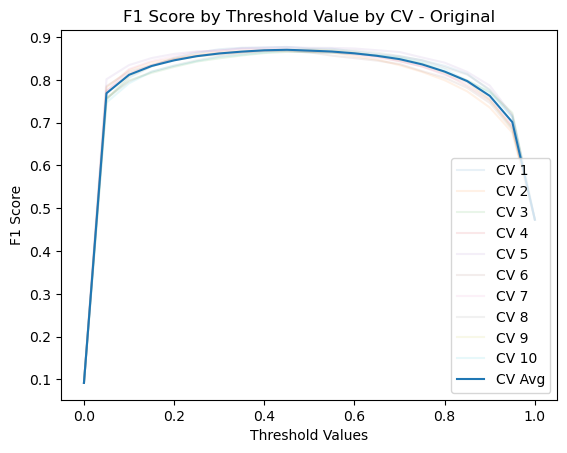

In [42]:
## F1 Macro Scores by Threshold
thresholds = np.arange(0,1.01,0.05)
plt.plot(thresholds,scores[0], alpha=0.1)
plt.plot(thresholds,scores[1], alpha=0.1)
plt.plot(thresholds,scores[2], alpha=0.1)
plt.plot(thresholds,scores[3], alpha=0.1)
plt.plot(thresholds,scores[4], alpha=0.1)
plt.plot(thresholds,scores[5], alpha=0.1)
plt.plot(thresholds,scores[6], alpha=0.1)
plt.plot(thresholds,scores[7], alpha=0.1)
plt.plot(thresholds,scores[8], alpha=0.1)
plt.plot(thresholds,scores[9], alpha=0.1)
plt.plot(thresholds,avg_score)
plt.title('F1 Score by Threshold Value by CV - Original')
plt.ylabel('F1 Score')
plt.xlabel('Threshold Values')
plt.legend(['CV 1', 'CV 2','CV 3','CV 4', 'CV 5', 'CV 6', 'CV 7', 'CV 8', 'CV 9', 'CV 10', 'CV Avg'], loc='lower right')
plt.show()

In [45]:
## LSTM CI from CV Results
cv_f1_score_lstm = []
for i in [0,1,2,3,4,5,6,7,8,9]:
    f1_cv = scores[i][np.arange(0,1.01,0.05)==best_threshold]
    cv_f1_score_lstm.append(f1_cv[0])
lstm_mean = np.mean(cv_f1_score_lstm)
lstm_std = np.std(cv_f1_score_lstm)
lstm_ci = [lstm_mean - 3*lstm_std, lstm_mean + 3*lstm_std] ## Includes 99.7% numbers around est. mean.

In [46]:
print("Mean CV Score: {}".format(lstm_mean))
print("Standard Deviation CV Score: {}".format(lstm_std))

Mean CV Score: 0.8702824188741103
Standard Deviation CV Score: 0.0036274724586236057


In [47]:
lstm_ci

[0.8594000014982395, 0.8811648362499811]

In [48]:
## Final Test on Test Data
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, 128)(inp)
x = Bidirectional(LSTM(52, return_sequences=True, dropout=0.333699, recurrent_dropout=0))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.32709)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(), 
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, batch_size=256)
y_pred = model.predict([X_test], batch_size=256, verbose=1)
y_pred = (y_pred > best_threshold).astype(int)
print('[LSTM] F1 Macro score is {}'.format(f1_score(y_test, y_pred, average = 'macro')))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Epoch 1/2
612/612 [==============================] - 19s 26ms/step - loss: 0.1809 - accuracy: 0.9359
Epoch 2/2
262/262 [==============================] - 3s 8ms/step
[LSTM] F1 Macro score is 0.8685497068319775
[[59254  1175]
 [ 1830  4806]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     60429
           1       0.80      0.72      0.76      6636

    accuracy                           0.96     67065
   macro avg       0.89      0.85      0.87     67065
weighted avg       0.95      0.96      0.95     67065

